In [ ]:
!pip install obspy
import obspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, correlate, hilbert
from scipy.interpolate import CubicSpline
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from obspy import read, Stream, Trace
import plotly.graph_objects as go
from scipy.interpolate import griddata, interp1d


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and display the first few lines of the interval velocity data file
def load_raw_velocity_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines[:10]):  # Only print the first 10 lines to inspect the file
            print(f"Line {i}: {line.strip()}")

# Load and display the first few lines of the navigation (SDL) file
def load_raw_navigation_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines[:10]):  # Only print the first 10 lines to inspect the file
            print(f"Line {i}: {line.strip()}")

# Load the seismic data (SEGY) file using ObsPy
def load_raw_seismic_data(file_path):
    import obspy
    seismic_data = obspy.read(file_path)
    print(seismic_data)  # summary of the seismic data
    return seismic_data

# File paths (update these to your correct paths)
velocity_file = '/content/drive/MyDrive/Senior Project/line1_interval'
sdl_file = '/content/drive/MyDrive/Senior Project/line1.sdl'
segy_file = '/content/drive/MyDrive/Senior Project/line1_stack.segy'

# Load raw data
print("Velocity Data (Raw):")
load_raw_velocity_data(velocity_file)

print("\nNavigation Data (Raw):")
load_raw_navigation_data(sdl_file)

print("\nSeismic Data (Raw):")
seismic_data = load_raw_seismic_data(segy_file)  # Seismic data is loaded using ObsPy

Velocity Data (Raw):
Line 0: DESC=interval_depth_smooth
Line 1: PKEYNAME=CDP
Line 2: SKEYNAME=DEPTH
Line 3: ZKEYNAME=VID
Line 4: CDP=    40.0
Line 5: DEPTH=    0.00       VID= 1480.56
Line 6: DEPTH=   10.00       VID= 1480.56
Line 7: DEPTH=   20.00       VID= 1480.56
Line 8: DEPTH=   30.00       VID= 1480.56
Line 9: DEPTH=   40.00       VID= 1480.57

Navigation Data (Raw):
Line 0: 1    	40.25882	-69.95056 Line1_Stack
Line 1: 2    	40.25887	-69.95059 Line1_Stack
Line 2: 3    	40.25892	-69.95062 Line1_Stack
Line 3: 4    	40.25897	-69.95064 Line1_Stack
Line 4: 5    	40.25903	-69.95067 Line1_Stack
Line 5: 6    	40.25908	-69.95070 Line1_Stack
Line 6: 7    	40.25913	-69.95073 Line1_Stack
Line 7: 8    	40.25919	-69.95075 Line1_Stack
Line 8: 9    	40.25924	-69.95078 Line1_Stack
Line 9: 10   	40.25929	-69.95081 Line1_Stack

Seismic Data (Raw):
18322 Trace(s) in Stream:

Seq. No. in line:    0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.999500Z | 2000.0 Hz, 8000 samples
...
(18320 other 

In [ ]:
def load_velocity_data(file_path):
    # Open the file and filter out metadata lines (e.g., DESC, PKEYNAME)
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    current_cdp = None

    for line in lines:
        line = line.strip()

        # If the line defines a CDP, capture its value
        if line.startswith('CDP='):
            try:
                current_cdp = float(line.split('=')[1].strip())
            except ValueError:
                print(f"Skipping invalid CDP line: {line}")

        # Otherwise, parse depth and velocity values
        elif line.startswith('DEPTH='):
            parts = line.split()
            if len(parts) >= 4:
                try:
                    depth = float(parts[1])
                    velocity = float(parts[3])
                    # Include the CDP in the data
                    data.append([current_cdp, depth, velocity])
                except ValueError:
                    print(f"Skipping invalid data line: {line}")
            else:
                print(f"Skipping line with insufficient parts: {line}")

    # Convert to DataFrame with CDP included
    df = pd.DataFrame(data, columns=['CDP', 'DEPTH', 'VELOCITY'])
    return df

# Load the velocity data
velocity_file = '/content/drive/MyDrive/Senior Project/line1_interval'
velocity_data = load_velocity_data(velocity_file)

# Inspect the cleaned velocity data with CDP information
print(velocity_data.head())

# Extract delta T from the seismic data metadata
delta_t = seismic_data[0].stats.delta  # Retrieve sample interval in seconds
print("Delta T (Sample Interval):", delta_t)

    CDP  DEPTH  VELOCITY
0  40.0    0.0   1480.56
1  40.0   10.0   1480.56
2  40.0   20.0   1480.56
3  40.0   30.0   1480.56
4  40.0   40.0   1480.57
Delta T (Sample Interval): 0.0005


In [ ]:
# Smooth the velocity data with a low-pass filter
def smooth_velocity_model(velocity, cutoff_frequency=0.1, order=2):
    nyquist = 0.5 * len(velocity)
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, velocity)

smoothed_velocity = smooth_velocity_model(velocity_data['VELOCITY'].values)

In [ ]:
# Define the depth conversion function with truncation
def create_time_axis(trace, delta_t):
    n_samples = trace.stats.npts
    return np.arange(n_samples) * delta_t

def time_to_depth_conversion_with_truncation(seismic_data, velocity_model, max_depth_limit=2770):
    depth_converted_data = []
    depth_axes = []

    for trace in seismic_data:
        time_axis = create_time_axis(trace, trace.stats.delta)
        depth_axis = np.zeros_like(time_axis)

        for i in range(1, len(time_axis)):
            depth_axis[i] = depth_axis[i-1] + (time_axis[i] - time_axis[i-1]) * velocity_model[min(i, len(velocity_model)-1)]
            if depth_axis[i] > max_depth_limit:
                depth_axis = depth_axis[:i]
                trace_data = trace.data[:i]
                break
        else:
            trace_data = trace.data  # No truncation needed if limit isn't reached

        depth_converted_data.append(trace_data)
        depth_axes.append(depth_axis)

    return depth_converted_data, depth_axes

# Apply the conversion function
depth_converted_data, depth_axes = time_to_depth_conversion_with_truncation(seismic_data, smoothed_velocity)


In [ ]:
# Define the directory path
save_directory = '/content/drive/MyDrive/Senior_Project/'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

print(f"Directory checked/created at: {save_directory}")

Directory checked/created at: /content/drive/MyDrive/Senior_Project/


In [ ]:
# Save depth converted data
np.save(os.path.join(save_directory, 'depth_axes.npy'), depth_axes)
np.save(os.path.join(save_directory, 'depth_converted_data.npy'), depth_converted_data)

print("Depth saved successfully.")

Depth saved successfully.


In [ ]:
# AGC function for applying gain control to individual traces ...... 45 MINUTE RUNTIME
def apply_agc(trace, window_size=1000):
    agc_trace = np.zeros_like(trace)
    for i in range(len(trace)):
        start = max(i - window_size // 2, 0)
        end = min(i + window_size // 2, len(trace))
        window_rms = np.sqrt(np.mean(trace[start:end] ** 2))
        if window_rms > 0:
            agc_trace[i] = trace[i] / window_rms
    return agc_trace

# Standalone function for processing traces with AGC
def process_trace_with_agc(trace, window_size):
    return apply_agc(trace, window_size)

# AGC application function using ProcessPoolExecutor without lambda (if needed)
def apply_agc_to_seismic_data(seismic_data, window_size=1000):
    with ProcessPoolExecutor() as executor:
        agc_data = list(executor.map(process_trace_with_agc, seismic_data, [window_size]*len(seismic_data)))
    return agc_data

# Apply AGC to depth-converted data
window_size = 1000  # Adjust based on data needs
agc_traces_depth_converted = apply_agc_to_seismic_data(depth_converted_data, window_size)

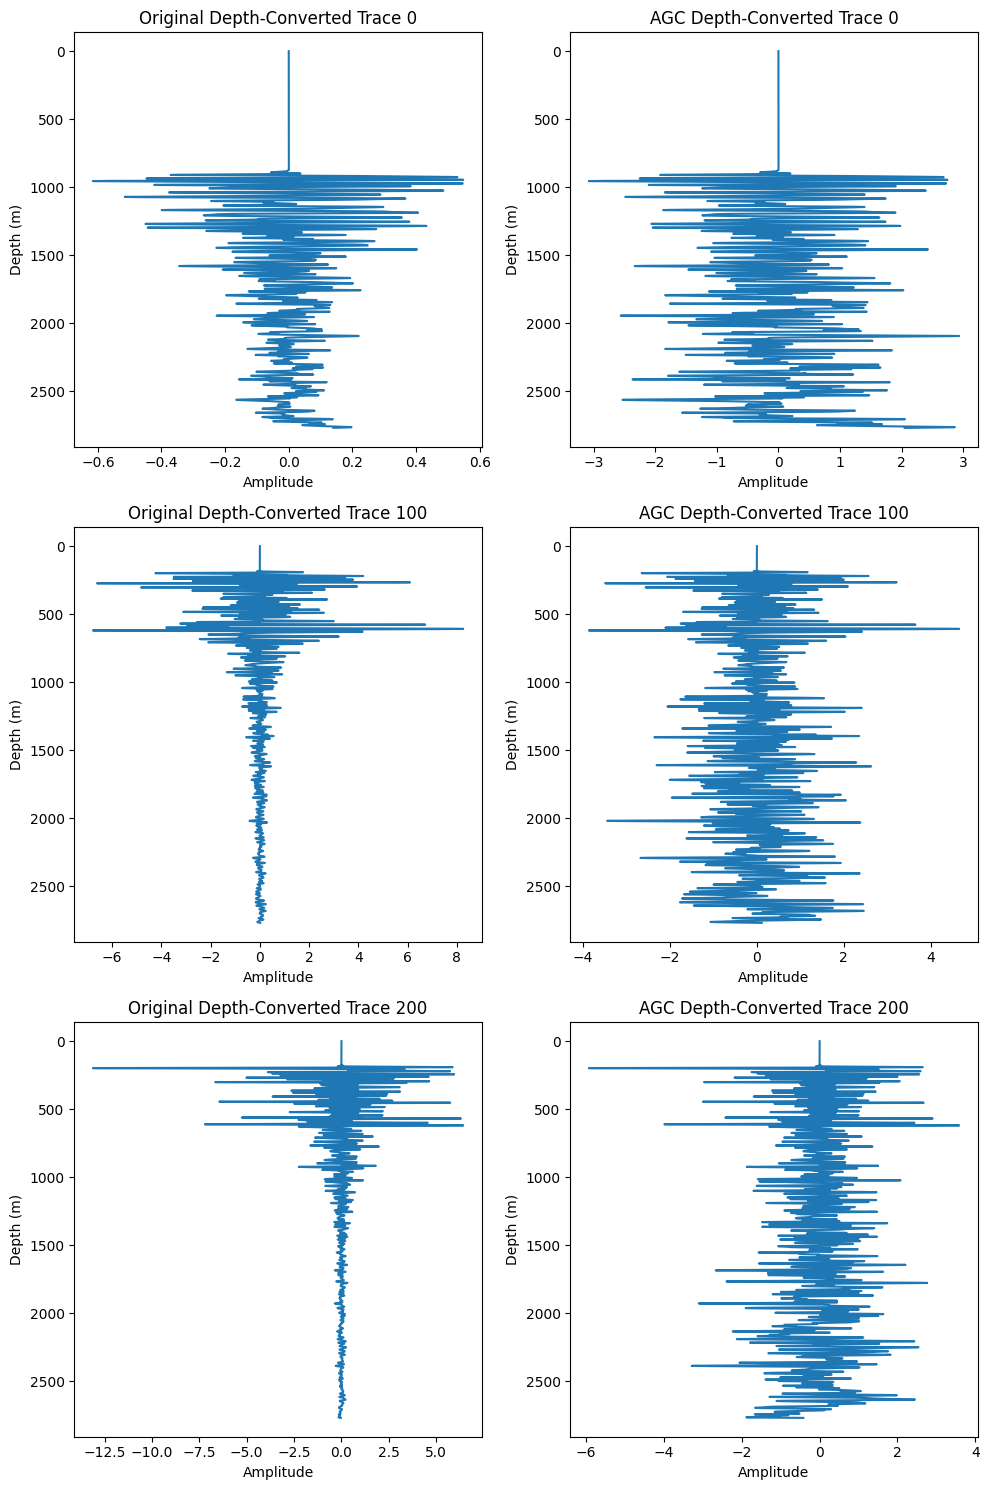

In [ ]:
# Plotting Original vs. AGC for comparison
def plot_traces(original_data, agc_data, depth_axes, trace_indices):
    fig, axes = plt.subplots(nrows=len(trace_indices), ncols=2, figsize=(10, 5 * len(trace_indices)))

    for i, trace_idx in enumerate(trace_indices):
        axes[i, 0].plot(original_data[trace_idx], depth_axes[trace_idx])
        axes[i, 0].set_title(f"Original Depth-Converted Trace {trace_idx}")
        axes[i, 0].set_xlabel("Amplitude")
        axes[i, 0].set_ylabel("Depth (m)")
        axes[i, 0].invert_yaxis()

        axes[i, 1].plot(agc_data[trace_idx], depth_axes[trace_idx])
        axes[i, 1].set_title(f"AGC Depth-Converted Trace {trace_idx}")
        axes[i, 1].set_xlabel("Amplitude")
        axes[i, 1].set_ylabel("Depth (m)")
        axes[i, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Select trace indices to plot
trace_indices_to_plot = [0, 100, 200]
plot_traces(depth_converted_data, agc_traces_depth_converted, depth_axes, trace_indices_to_plot)


## Save AGC Converted data for future use

In [ ]:
import os

# Define the directory path
save_directory = '/content/drive/MyDrive/Senior_Project/'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

print(f"Directory checked/created at: {save_directory}")


Directory checked/created at: /content/drive/MyDrive/Senior_Project/


In [ ]:
import numpy as np

# Save the AGC-corrected traces to the file
np.save(os.path.join(save_directory, 'agc_traces.npy'), agc_traces_depth_converted)

print("AGC-corrected traces saved successfully.")

AGC-corrected traces saved successfully.


# RUN PROCESSED .npy DATA FROM HERE (AGC TAKES 45 MIN)


In [ ]:
# Load the AGC-corrected seismic traces
agc_traces = np.load('/content/drive/MyDrive/Senior_Project/agc_traces.npy')
depth_axes = np.load('/content/drive/MyDrive/Senior_Project/depth_axes.npy')
depth_converted_data = np.load('/content/drive/MyDrive/Senior_Project/depth_converted_data.npy')

In [ ]:
# Function to parse SDL file and extract navigation data
def load_navigation_from_sdl(file_path):
    navigation_data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Split the line by whitespace and capture coordinates
        parts = line.split()
        if len(parts) >= 3:
            try:
                lat = float(parts[1])  # Latitude
                lon = float(parts[2])  # Longitude
                navigation_data.append((lat, lon))
            except ValueError:
                continue  # Skip any lines with invalid data

    return navigation_data

# Haversine formula to calculate the distance between two points on the Earth
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of the Earth in kilometers
    R = 6371.0
    return c * R  # Result in kilometers

# Load the navigation data
sdl_file_path = '/content/drive/MyDrive/Senior Project/line1.sdl'
navigation_data = load_navigation_from_sdl(sdl_file_path)

# Calculate distances from shoreline
shoreline_lat, shoreline_lon = navigation_data[0]
distances_from_shoreline = [haversine(shoreline_lat, shoreline_lon, lat, lon) for lat, lon in navigation_data]

# Filter for 30 to 100 km range
filtered_indices = [i for i, d in enumerate(distances_from_shoreline) if 30 <= d <= 100]

print("Filtered navigation indices:", filtered_indices)

Filtered navigation indices: [4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954

In [ ]:
# Filter uncorrected and AGC-corrected depth-converted seismic data
depth_converted_data_filtered = [depth_converted_data[i] for i in filtered_indices]
depth_axes_filtered = [depth_axes[i] for i in filtered_indices]

# Ensure that AGC data is loaded
depth_converted_agc_data_filtered = [agc_traces[i] for i in filtered_indices]

In [ ]:
# Update the depth truncation limit
depth_truncation_limit = 1000  # 1 km

# Re-truncate depth-converted data (both original and AGC-corrected)
depth_converted_data_truncated = [trace[:np.argmax(axis >= depth_truncation_limit)] for trace, axis in zip(depth_converted_data_filtered, depth_axes_filtered)]
depth_converted_agc_data_truncated = [trace[:np.argmax(axis >= depth_truncation_limit)] for trace, axis in zip(depth_converted_agc_data_filtered, depth_axes_filtered)]
depth_axes_truncated = [axis[axis < depth_truncation_limit] for axis in depth_axes_filtered]

## Ensure distance and depth conversion work correctly

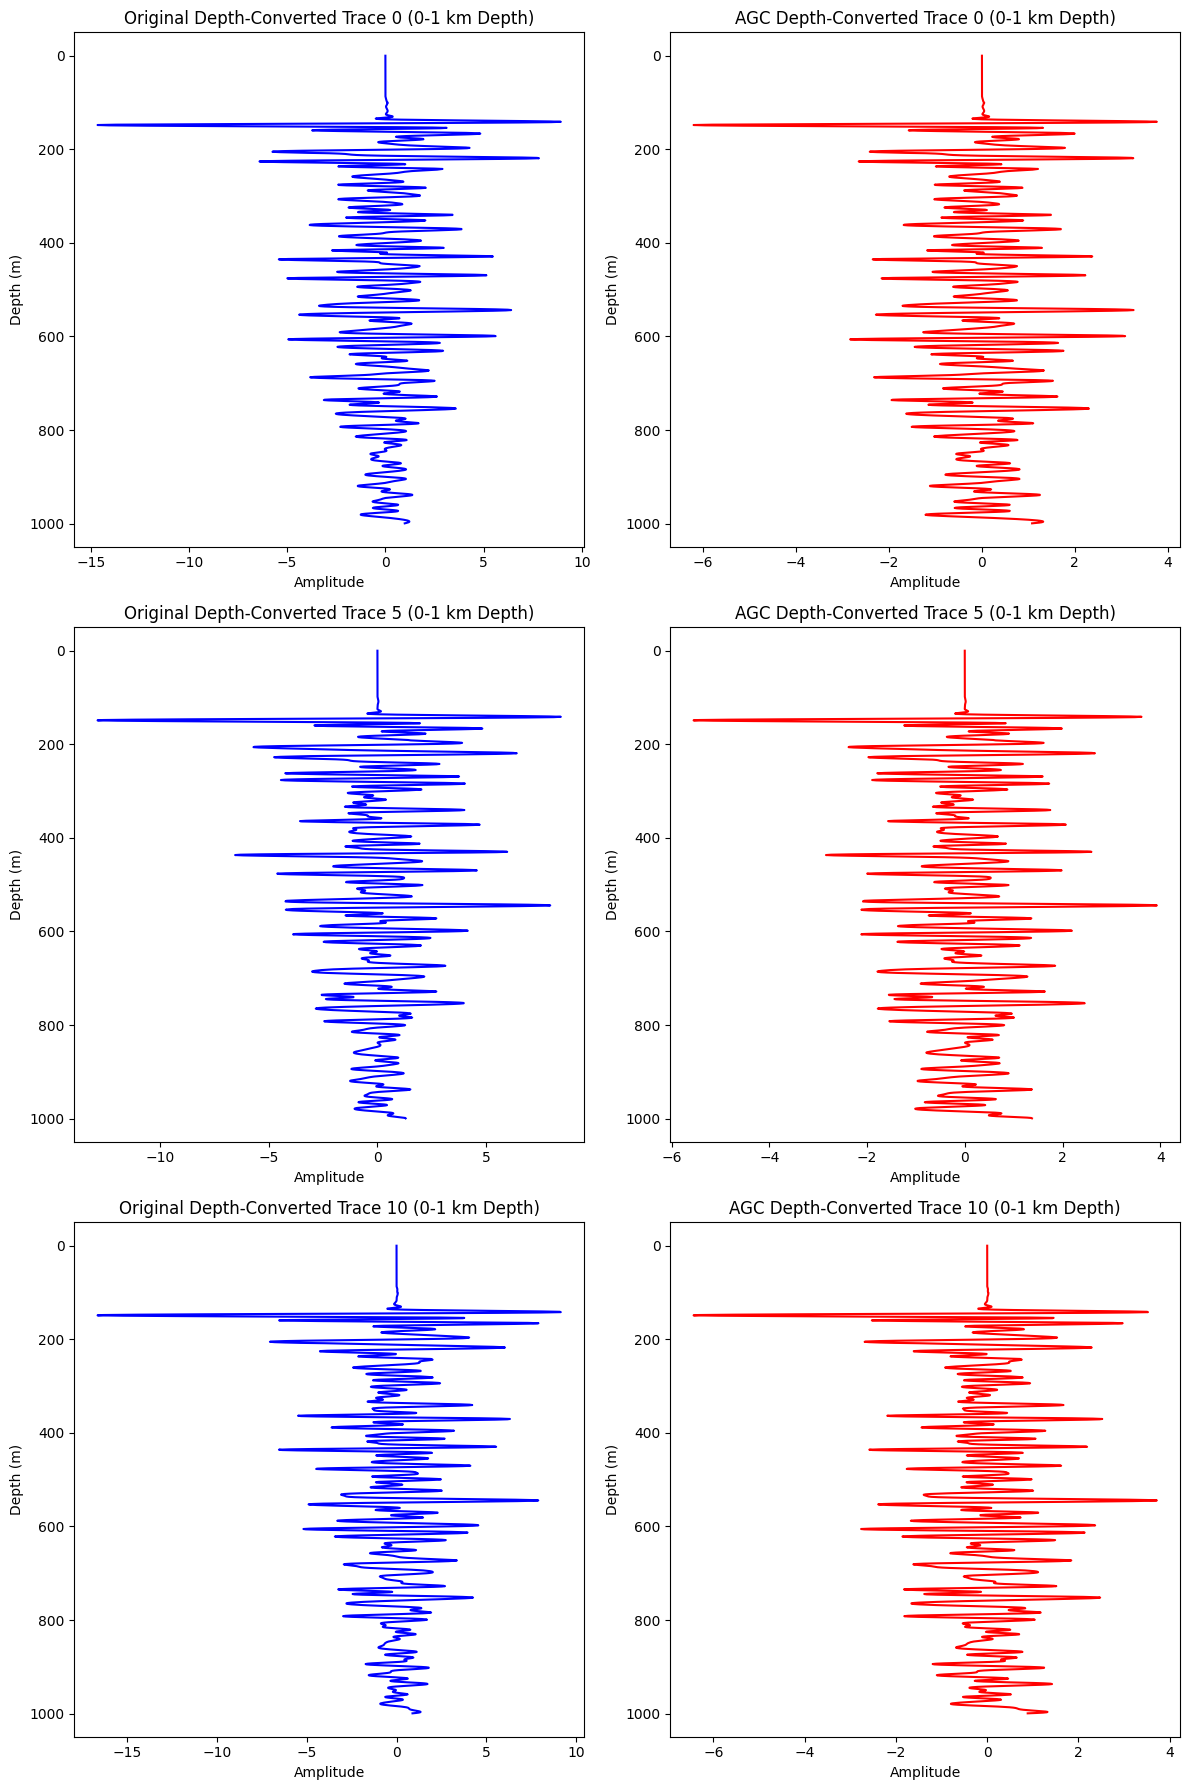

In [ ]:
def plot_truncated_section(original_data, agc_data, depth_axes, trace_indices):
    """
    Plot truncated depth-converted seismic traces for comparison.

    Parameters:
    original_data: Truncated original depth-converted seismic traces
    agc_data: Truncated AGC-corrected depth-converted seismic traces
    depth_axes: Corresponding truncated depth axes for each trace
    trace_indices: List of indices of traces to plot
    """
    fig, axes = plt.subplots(nrows=len(trace_indices), ncols=2, figsize=(12, 6 * len(trace_indices)))

    for i, trace_idx in enumerate(trace_indices):
        # Plot original depth-converted trace
        axes[i, 0].plot(original_data[trace_idx], depth_axes[trace_idx], color='blue')
        axes[i, 0].set_title(f"Original Depth-Converted Trace {trace_idx} (0-1 km Depth)")
        axes[i, 0].set_xlabel("Amplitude")
        axes[i, 0].set_ylabel("Depth (m)")
        axes[i, 0].invert_yaxis()

        # Plot AGC depth-converted trace
        axes[i, 1].plot(agc_data[trace_idx], depth_axes[trace_idx], color='red')
        axes[i, 1].set_title(f"AGC Depth-Converted Trace {trace_idx} (0-1 km Depth)")
        axes[i, 1].set_xlabel("Amplitude")
        axes[i, 1].set_ylabel("Depth (m)")
        axes[i, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Plotting the truncated traces
trace_indices_to_plot = [0, 5, 10]  # Adjust based on interest
plot_truncated_section(depth_converted_data_truncated, depth_converted_agc_data_truncated, depth_axes_truncated, trace_indices_to_plot)

## Save as SEG-Y File for future use

In [ ]:
# Convert filtered original and AGC depth-converted traces into ObsPy Stream objects
stream_original = Stream([Trace(data=trace.astype(np.float32)) for trace in depth_converted_data_filtered])
stream_agc = Stream([Trace(data=trace.astype(np.float32)) for trace in depth_converted_agc_data_filtered])

# Define the sample rate (if known) and depth interval for the traces
for trace in stream_original + stream_agc:
    trace.stats.sampling_rate = 1 / delta_t  # Set to the actual sampling rate
    trace.stats.delta = delta_t  # Ensure delta_t is correctly set

# Define file paths
output_directory = "/content/drive/MyDrive/Senior Project"
original_segy_path = f"{output_directory}/filtered_original_seismic_data.sgy"
agc_segy_path = f"{output_directory}/filtered_agc_seismic_data.sgy"

# Save the filtered original and AGC-corrected data as SEG-Y without specifying data encoding
stream_original.write(original_segy_path, format="SEGY")
stream_agc.write(agc_segy_path, format="SEGY")

print("Files saved to:", output_directory)


/usr/local/lib/python3.10/dist-packages/obspy/io/segy/core.py:362: UserWarning:

CREATING TRACE HEADER



Files saved to: /content/drive/MyDrive/Senior Project


# Start fully processed data inspection from here (use SEG-Y file)

In [ ]:
# Path to AGC-corrected SEG-Y file
segy_path = "/content/drive/MyDrive/Senior Project/filtered_agc_seismic_data.sgy"

# Load the SEG-Y file
stream = read(segy_path, format="SEGY")

# Display general information about the SEG-Y file
print(f"Total number of traces: {len(stream)}")
print(f"Sampling rate (should reflect depth intervals): {stream[0].stats.sampling_rate} samples per second")
print(f"Samples per trace (depth points): {stream[0].stats.npts}")
print(f"Trace duration: {stream[0].stats.npts / stream[0].stats.sampling_rate} seconds")

# Print details for the first few traces to check the structure
for i, trace in enumerate(stream[:5]):  # Check the first 5 traces for clarity
    depth_points = len(trace.data)
    depth_axis = np.linspace(0, 1000, depth_points)  # Assuming a 1000 m depth range
    print(f"\nTrace {i+1} (Distance from shoreline ~{30 + (i * 70 / len(stream)):.2f} km):")
    print(f"  Depth Axis (first few values): {depth_axis[:5]} meters")
    print(f"  Max amplitude: {max(trace.data)}")
    print(f"  Min amplitude: {min(trace.data)}")



Total number of traces: 11192
Sampling rate (should reflect depth intervals): 2000.0 samples per second
Samples per trace (depth points): 3628
Trace duration: 1.814 seconds

Trace 1 (Distance from shoreline ~30.00 km):
  Depth Axis (first few values): [0.         0.27570995 0.55141991 0.82712986 1.10283981] meters
  Max amplitude: 3.765542984008789
  Min amplitude: -6.20860481262207

Trace 2 (Distance from shoreline ~30.01 km):
  Depth Axis (first few values): [0.         0.27570995 0.55141991 0.82712986 1.10283981] meters
  Max amplitude: 3.621755599975586
  Min amplitude: -5.40892219543457

Trace 3 (Distance from shoreline ~30.01 km):
  Depth Axis (first few values): [0.         0.27570995 0.55141991 0.82712986 1.10283981] meters
  Max amplitude: 3.7914047241210938
  Min amplitude: -6.326066017150879

Trace 4 (Distance from shoreline ~30.02 km):
  Depth Axis (first few values): [0.         0.27570995 0.55141991 0.82712986 1.10283981] meters
  Max amplitude: 3.750720977783203
  Min am

# Defines class sytem that is copied and further deveolped upon in seperate seismic processing notebook to reduce clutter.

In [ ]:
# Class system repeated and developed upon in more detailed "Seismic Processing Notebook"
class seismicgather:
    def __init__(self):
        self.data = []
        self.rx = None
        self.rz = None
        self.delta_t = None

    def read_segy_data(self, segy_path):
        stream = read(segy_path, format="SEGY")
        self.delta_depth = 0.2757  # Depth interval in meters, as observed

        # Set up the range for distance from shoreline: 30 to 100 km across all traces
        distance_range = np.linspace(100, 0, len(stream))  # Reverse distance range

        for i, trace in enumerate(stream):
            geodata_instance = geodata()
            geodata_instance.data = trace.data
            geodata_instance.rx = distance_range[i]  # Map distance from shoreline for each trace (reversed)
            geodata_instance.depth_axis = np.arange(len(trace.data)) * self.delta_depth  # Depth in meters
            self.data.append(geodata_instance)

    def read_npy_data(self, npy_path, distance_range, depth_interval=0.2757):
        """
        Read depth-converted seismic data from a .npy file and flip horizontally.

        Parameters:
        - npy_path: Path to the .npy file
        - distance_range: Range of distances corresponding to traces (tuple: start, end)
        - depth_interval: Interval between depth samples in meters
        """
        seismic_data = np.load(npy_path)
        seismic_data = np.flip(seismic_data, axis=0)  # Flip horizontally
        num_traces, num_depths = seismic_data.shape
        self.delta_depth = depth_interval
        distances = np.linspace(distance_range[0], distance_range[1], num_traces)

        for i, trace_amplitudes in enumerate(seismic_data):
            geodata_instance = geodata()
            geodata_instance.data = trace_amplitudes
            geodata_instance.rx = distances[i]
            geodata_instance.depth_axis = np.arange(num_depths) * self.delta_depth
            self.data.append(geodata_instance)

    def wiggle_plot_depth_distance(self, scale=20, trace_step=500):
        fig, ax = plt.subplots(figsize=(14, 6))

        for i, trace in enumerate(self.data[::trace_step]):
            data_norm = trace.data / np.max(np.abs(trace.data)) if np.max(np.abs(trace.data)) != 0 else trace.data
            distance_value = trace.rx  # Distance from shoreline
            ax.plot(data_norm * scale + distance_value, trace.depth_axis, 'k')

        ax.set_xlim(00, 100)
        ax.set_ylim(0, 1000)
        ax.set_xlabel('Distance from Shoreline (km)')
        ax.set_ylabel('Depth (m)')
        ax.invert_yaxis()
        plt.title("Wiggle Plot of Seismic Data (30 to 100 km)")
        plt.show()

    def isolate_section(self, distance_min, distance_max, depth_min, depth_max):
        # Filter the traces based on the distance and depth range
        selected_data = []
        for trace in self.data:
            if distance_min <= trace.rx <= distance_max:
                depth_indices = (trace.depth_axis >= depth_min) & (trace.depth_axis <= depth_max)
                selected_data.append((trace.rx, trace.depth_axis[depth_indices], trace.data[depth_indices]))

        return selected_data

    def wiggle_plot_constrained(self, distance_min, distance_max, depth_min, depth_max, scale=0.1, trace_step=5, offset=0.1):
        """
        Plot wiggle plots constrained by depth and distance ranges with better clarity.

        Parameters:
        - distance_min, distance_max: Range of distances for the wiggle plot
        - depth_min, depth_max: Range of depths for the wiggle plot
        - scale: Scale factor for the wiggle plot
        - trace_step: Step size for selecting traces to plot
        - offset: Horizontal offset between traces to avoid complete overlap
        """
        fig, ax = plt.subplots(figsize=(14, 6))

        for i, trace in enumerate(self.data):
            if distance_min <= trace.rx <= distance_max and i % trace_step == 0:
                data_norm = trace.data / np.max(np.abs(trace.data)) if np.max(np.abs(trace.data)) != 0 else trace.data
                distance_value = trace.rx + offset * i  # Add offset to avoid overlap
                depth_indices = (trace.depth_axis >= depth_min) & (trace.depth_axis <= depth_max)
                ax.plot(data_norm[depth_indices] * scale + distance_value, trace.depth_axis[depth_indices], 'k')

        ax.set_xlim(distance_min, distance_max)
        ax.set_ylim(depth_min, depth_max)
        ax.set_xlabel('Distance from Shoreline (km)')
        ax.set_ylabel('Depth (m)')
        ax.invert_yaxis()
        plt.title(f"Wiggle Plot: {distance_min}-{distance_max} km, {depth_min}-{depth_max} m")
        plt.show()


    def calculate_amplitude_envelope(self, distance_min, distance_max):
        """
        Calculate amplitude envelopes for traces within a specific distance range.
        """
        envelopes = []
        depths = []
        distances = []
        for trace in self.data:
            if distance_min <= trace.rx <= distance_max:
                analytic_signal = hilbert(trace.data)
                envelope = np.abs(analytic_signal)  # Amplitude envelope
                envelopes.append(envelope)
                depths.append(trace.depth_axis)
                distances.append(trace.rx)
        return np.array(distances), np.array(depths), np.array(envelopes)

    def wiggle_plot_with_envelope(self, distance_min, distance_max, depth_min, depth_max, scale=0.1, trace_step=1, offset=0000.1):
        """
        Create a wiggle plot with amplitude envelope overlay and offset for a constrained window.

        Parameters:
        - distance_min, distance_max: Range of distances for the wiggle plot
        - depth_min, depth_max: Range of depths for the wiggle plot
        - scale: Scale factor for the wiggle plot
        - trace_step: Step size for selecting traces to plot
        - offset: Horizontal offset between traces to avoid overlap
        """
        fig, ax = plt.subplots(figsize=(12, 6))

        for i, trace in enumerate(self.data):
            if distance_min <= trace.rx <= distance_max and i % trace_step == 0:
                # Constrain depth range
                depth_mask = (trace.depth_axis >= depth_min) & (trace.depth_axis <= depth_max)
                constrained_depth = trace.depth_axis[depth_mask]
                constrained_data = trace.data[depth_mask]

                # Normalize for wiggle scaling
                data_norm = constrained_data / np.max(np.abs(constrained_data)) if np.max(np.abs(constrained_data)) != 0 else constrained_data

                # Apply offset to avoid overlapping
                distance_value = trace.rx + i * offset
                ax.plot(data_norm * scale + distance_value, constrained_depth, 'k')

       # Calculate amplitude envelopes
        for i, trace in enumerate(self.data):
            if distance_min <= trace.rx <= distance_max:
                analytic_signal = hilbert(trace.data)
                envelope = np.abs(analytic_signal)

                # Constrain depth range for the envelope
                depth_mask = (trace.depth_axis >= depth_min) & (trace.depth_axis <= depth_max)
                constrained_depth = trace.depth_axis[depth_mask]
                constrained_envelope = envelope[depth_mask]

                # Apply offset and overlay envelope
                distance_value = trace.rx + i * offset
                ax.plot(constrained_envelope * scale + distance_value, constrained_depth, color='red', alpha=0.6)

        # Plot formatting
        ax.set_xlim(distance_min, distance_max + offset * len(self.data))
        ax.set_ylim(depth_min, depth_max)
        ax.invert_yaxis()
        ax.set_xlabel("Distance from Shoreline (km)")
        ax.set_ylabel("Depth (m)")
        ax.set_title(f"Wiggle Plot with Envelope and Offset: {distance_min}-{distance_max} km, {depth_min}-{depth_max} m")
        plt.show()


class geodata:
    def __init__(self):
        self.data = None
        self.rx = None
        self.delta_t = None
        self.taxis = None

    def get_taxis(self):
        self.taxis = np.arange(len(self.data)) * self.delta_t

# Plotting Original Data. File needed to be mirrored due to given structure.

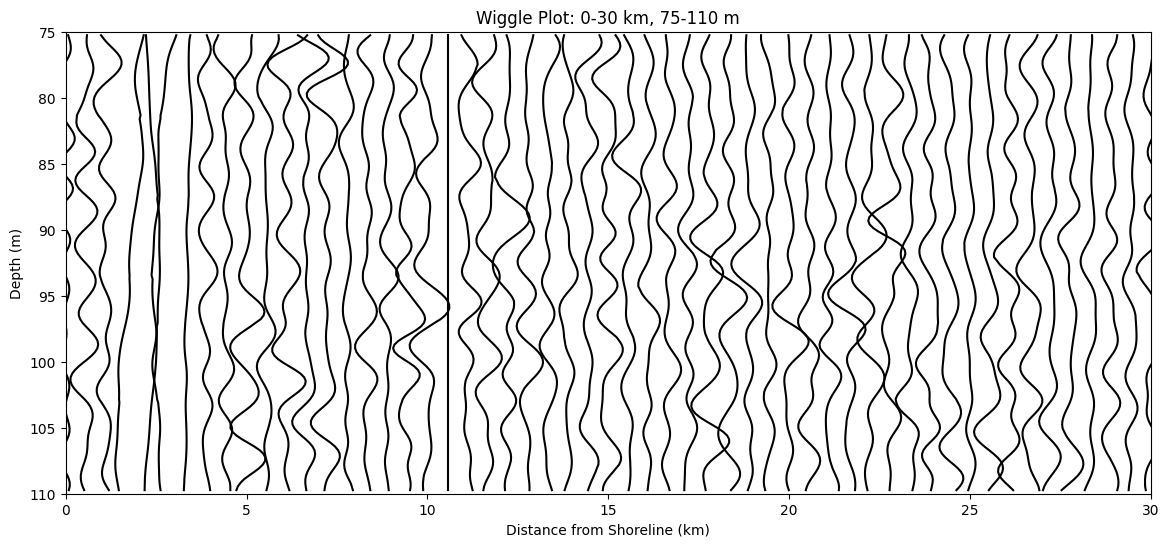

In [ ]:
# Initialize the seismic data object
seismic_data = seismicgather()
npy_path = "/content/drive/MyDrive/Senior_Project/depth_converted_data.npy"
distance_range = (0, 100)  # Define the range based on your data
seismic_data.read_npy_data(npy_path, distance_range)

# Plot constrained wiggle plot
distance_min, distance_max = 0, 30  # Adjust as needed
depth_min, depth_max = 75, 110  # Adjust as needed
seismic_data.wiggle_plot_constrained(distance_min, distance_max, depth_min, depth_max, scale=0.6, trace_step=100, offset=0.0001)

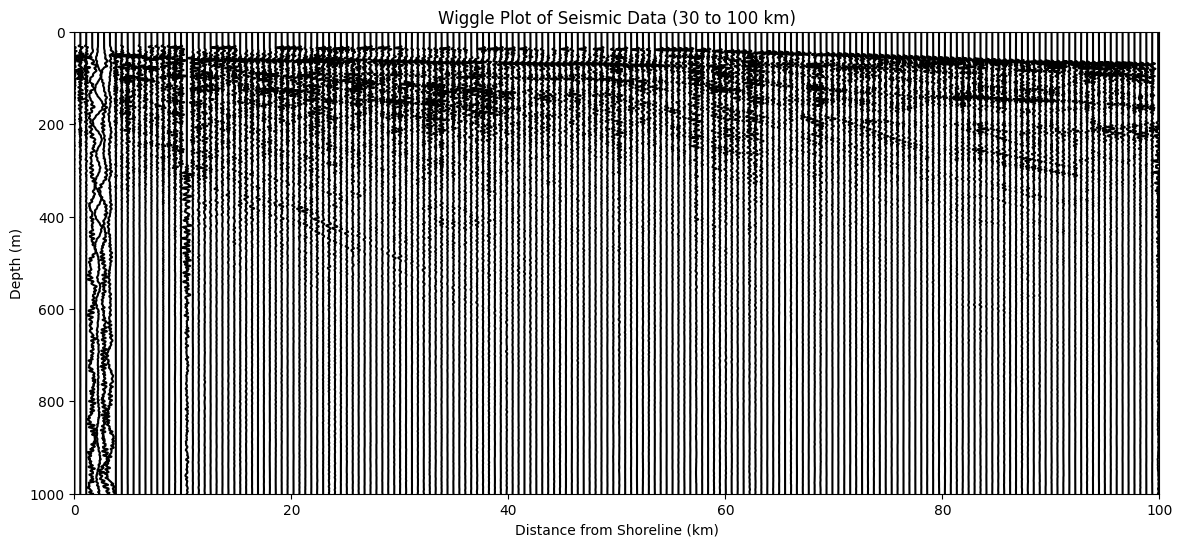

In [ ]:
# Plot the wiggle plot with the distance axis flipped, focusing on the 30-100 km and 0-1000 m range
seismic_data.wiggle_plot_depth_distance(scale=0.5, trace_step=100)

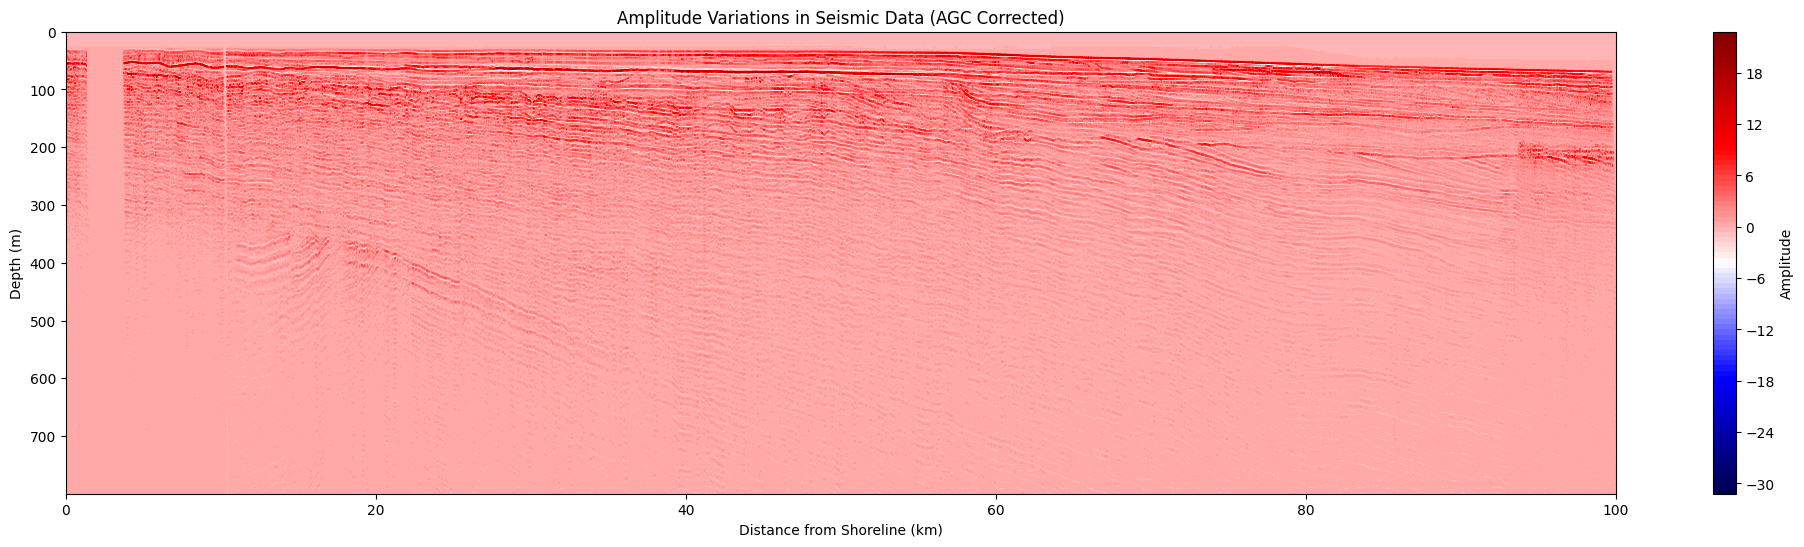

In [ ]:
# Isolate data for the observable range (aligns with publication and EM Data)
isolated_data = seismic_data.isolate_section(00, 100, 0, 800)

# Extract depth, distance, and amplitude values from isolated data
distance_values = np.array([trace[0] for trace in isolated_data])
depth_values = isolated_data[0][1]  # Depth values are the same for each trace in this range
amplitude_matrix = np.array([trace[2] for trace in isolated_data])

# Create a contour plot of the isolated section
plt.figure(figsize=(25, 6))
plt.contourf(distance_values, depth_values, amplitude_matrix.T, cmap="seismic", levels=100)
plt.colorbar(label="Amplitude")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Amplitude Variations in Seismic Data (Original)")
plt.show()

# Now working with the AGC Corrected Data.

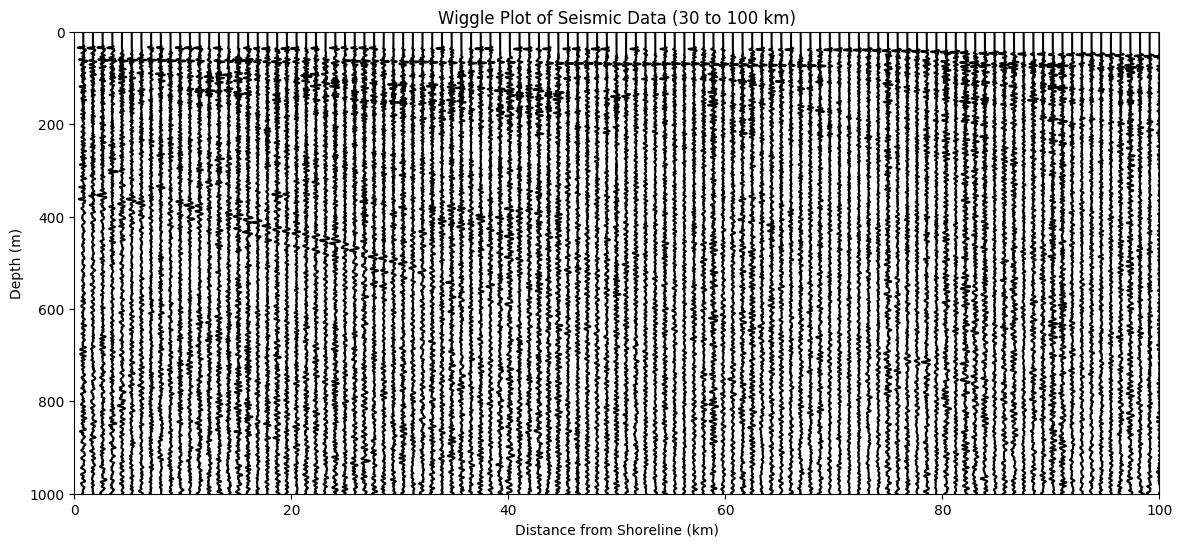

In [ ]:
# Initialize the seismic data object and read SEG-Y data
seismic_data_agc = seismicgather()
segy_path = "/content/drive/MyDrive/Senior Project/filtered_agc_seismic_data.sgy"
seismic_data_agc.read_segy_data(segy_path)

# Plot the wiggle plot with the distance axis flipped, focusing on the 30-100 km and 0-1000 m range
seismic_data_agc.wiggle_plot_depth_distance(scale=0.5, trace_step=100)

## Inspect raw traces for isolated range

In [ ]:
# Isolate data for the observable range (aligns with publication and EM Data)
isolated_data = seismic_data_agc.isolate_section(00, 100, 0, 800)

# Extract depth, distance, and amplitude values from isolated data
distance_values = np.array([trace[0] for trace in isolated_data])
depth_values = isolated_data[0][1]  # Depth values are the same for each trace in this range
amplitude_matrix = np.array([trace[2] for trace in isolated_data])

# Create a contour plot of the isolated section
plt.figure(figsize=(25, 6))
plt.contourf(distance_values, depth_values, amplitude_matrix.T, cmap="seismic", levels=100)
plt.colorbar(label="Amplitude")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Amplitude Variations in Seismic Data (AGC Corrected)")
plt.show()

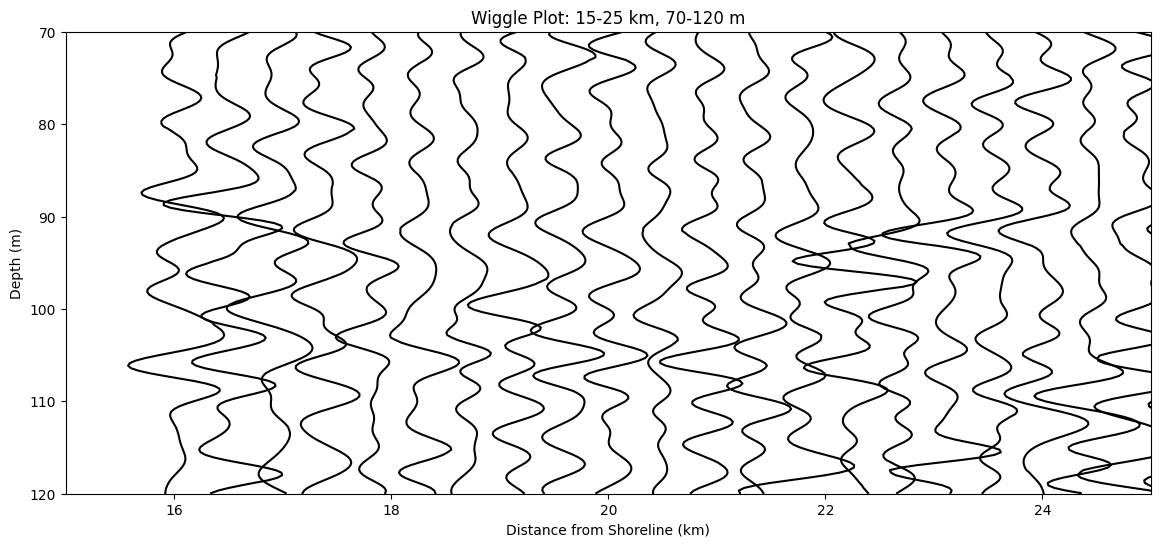

In [ ]:
# Plot constrained wiggle plot
distance_min, distance_max = 15, 25  # Adjust as needed
depth_min, depth_max = 70, 120  # Adjust as needed
seismic_data_agc.wiggle_plot_constrained(distance_min, distance_max, depth_min, depth_max, scale=0.6, trace_step=50, offset=0.0001)

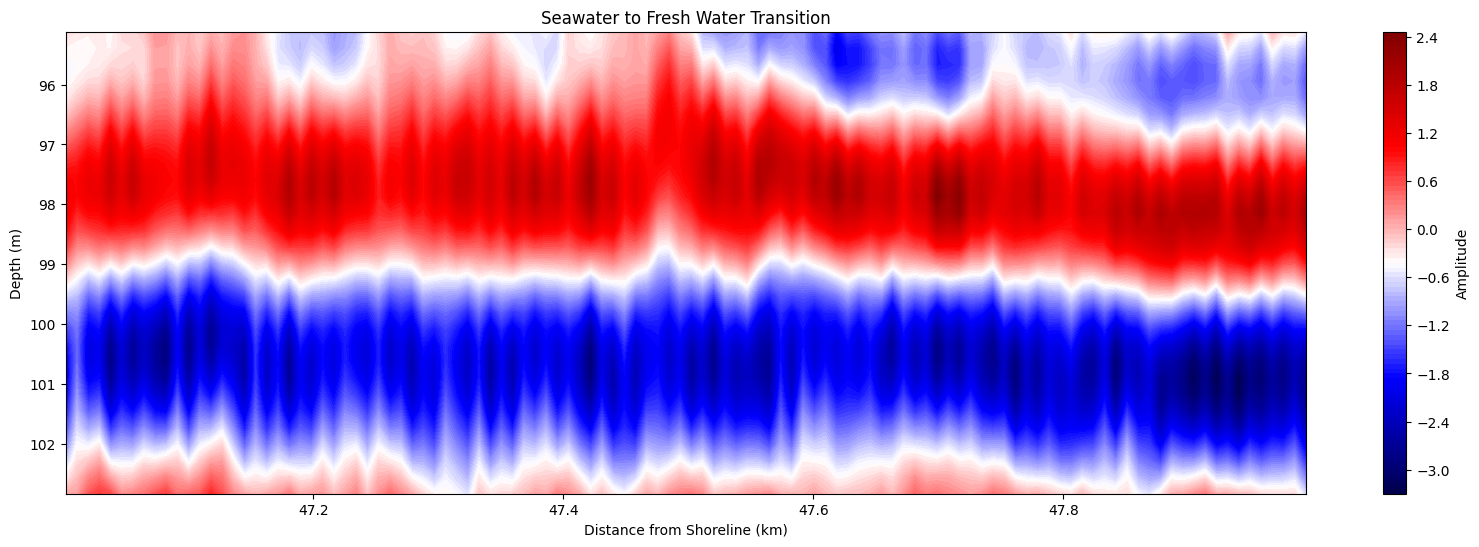

In [ ]:
# Isolate data
isolated_data = seismic_data.isolate_section(47, 48, 95, 103)

# Extract depth, distance, and amplitude values from isolated data
distance_values = np.array([trace[0] for trace in isolated_data])
depth_values = isolated_data[0][1]  # Depth values are the same for each trace in this range
amplitude_matrix = np.array([trace[2] for trace in isolated_data])

# Create a contour plot of the isolated section
plt.figure(figsize=(20, 6))
plt.contourf(distance_values, depth_values, amplitude_matrix.T, cmap="seismic", levels=100)
plt.colorbar(label="Amplitude")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Seawater to Fresh Water Transition")
plt.show()


In [ ]:
# Define the range for the wiggle plot
distance_min, distance_max = 47, 48  # Distance from shoreline in km
depth_min, depth_max = 97, 102       # Depth range in meters

# Isolate the data in this specific range
isolated_data = seismic_data.isolate_section(distance_min, distance_max, depth_min, depth_max)

# Extract depth, distance, and amplitude values for contour plot
distance_values = np.array([trace[0] for trace in isolated_data])
depth_values = isolated_data[0][1]  # Assuming depth is consistent across traces
amplitude_matrix = np.array([trace[2] for trace in isolated_data])

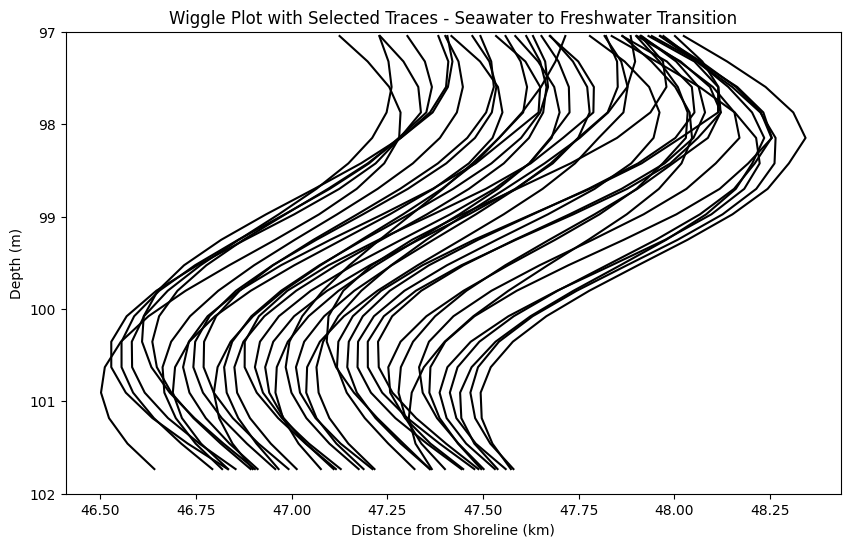

In [ ]:
selected_traces = seismic_data.isolate_section(distance_min, distance_max, depth_min, depth_max)

# Select every 5th trace to reduce density (adjust based on your data)
trace_step = max(1, len(selected_traces) // 30)  # Approximate to show ~30 traces

plt.figure(figsize=(10, 6))
scaling_factor = 0.5
for trace in selected_traces[::trace_step]:
    distance_value = trace[0]
    depth_values = trace[1]
    amplitude_values = trace[2] / np.max(np.abs(trace[2])) if np.max(np.abs(trace[2])) != 0 else trace[2]
    plt.plot(amplitude_values * scaling_factor + distance_value, depth_values, 'k')

plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.ylim(depth_min, depth_max)
plt.gca().invert_yaxis()
plt.title("Wiggle Plot with Selected Traces - Seawater to Freshwater Transition")
plt.show()

## Interactive Amplitude plot of isolated section

In [ ]:
import plotly.graph_objects as go

# Use a recognized colorscale in Plotly, like 'rdbu' (which is red-blue) or 'jet'
fig = go.Figure(data=go.Contour(
    z=amplitude_matrix.T,
    x=distance_values,
    y=depth_values,
    colorscale='rdbu',  # Update colorscale here
    contours=dict(start=-1, end=1, size=0.1),  # Adjust amplitude range based on your data
    colorbar=dict(title="Amplitude")
))

fig.update_layout(
    title="Interactive Amplitude Contour Plot",
    xaxis_title="Distance from Shoreline (km)",
    yaxis_title="Depth (m)",
    yaxis=dict(autorange="reversed"),  # Invert y-axis to match depth increase
    height=600,
    width=800
)

fig.show()



# Reloading the Velocity Data for Individual Investigation and Acoustic Impedance

In [ ]:
# Haversine function
def haversine(coord1, coord2):
    """
    Calculate the great-circle distance between two points
    on the Earth specified in decimal degrees.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0
    return R * c  # Distance in kilometers'

# Load the velocity data
def load_velocity_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    current_cdp = None

    for line in lines:
        line = line.strip()
        if line.startswith('CDP='):
            try:
                current_cdp = float(line.split('=')[1].strip())
            except ValueError:
                continue

        elif line.startswith('DEPTH='):
            parts = line.split()
            if len(parts) >= 4:
                try:
                    depth = float(parts[1])
                    velocity = float(parts[3])
                    data.append([current_cdp, depth, velocity])
                except ValueError:
                    continue

    df = pd.DataFrame(data, columns=['CDP', 'DEPTH', 'VELOCITY'])
    return df

# Load the navigation data
def load_navigation_from_sdl(file_path):
    navigation_data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.split()
        if len(parts) >= 3:
            try:
                cdp = int(parts[0])
                lat = float(parts[1])
                lon = float(parts[2])
                navigation_data.append((cdp, lat, lon))
            except ValueError:
                continue
    return pd.DataFrame(navigation_data, columns=['CDP', 'LAT', 'LON'])

# Load and calculate distances
navigation_data = load_navigation_from_sdl('/content/drive/MyDrive/Senior Project/line1.sdl')
shoreline_lat, shoreline_lon = navigation_data['LAT'].iloc[0], navigation_data['LON'].iloc[0]

# Calculate distances from the shoreline
navigation_data['DISTANCE'] = navigation_data.apply(
    lambda row: haversine((shoreline_lat, shoreline_lon), (row['LAT'], row['LON'])), axis=1
)

# Map distances to velocity data based on CDP
velocity_data = load_velocity_data('/content/drive/MyDrive/Senior Project/line1_interval')  # Assuming you have the load_velocity_data function

# Merge navigation data with velocity data on CDP
velocity_data = pd.merge(velocity_data, navigation_data[['CDP', 'DISTANCE']], on='CDP', how='inner')

# Filter by depth and distance ranges
velocity_data_filtered = velocity_data[(velocity_data['DEPTH'] <= 800) &
                                       (velocity_data['DISTANCE'] >= 0) &
                                       (velocity_data['DISTANCE'] <= 100)]

# Verify if data exists within this range
print("Filtered data size:", velocity_data_filtered.shape)
print(velocity_data_filtered.head())


Filtered data size: (25839, 4)
    CDP  DEPTH  VELOCITY  DISTANCE
0  40.0    0.0   1480.56   0.24402
1  40.0   10.0   1480.56   0.24402
2  40.0   20.0   1480.56   0.24402
3  40.0   30.0   1480.56   0.24402
4  40.0   40.0   1480.57   0.24402


In [ ]:
# Extract the filtered data columns
distances = velocity_data_filtered['DISTANCE'].values
depths = velocity_data_filtered['DEPTH'].values
velocities = velocity_data_filtered['VELOCITY'].values

# Define grid for interpolation
distance_grid = np.linspace(50, 60, 700)  # Increase number of points for smoother contours
depth_grid = np.linspace(200, 250, 700)

# Interpolate the data onto a regular grid for contour plotting
velocity_grid = griddata(
    (distances, depths),
    velocities,
    (distance_grid[None, :], depth_grid[:, None]),
    method='linear'
)

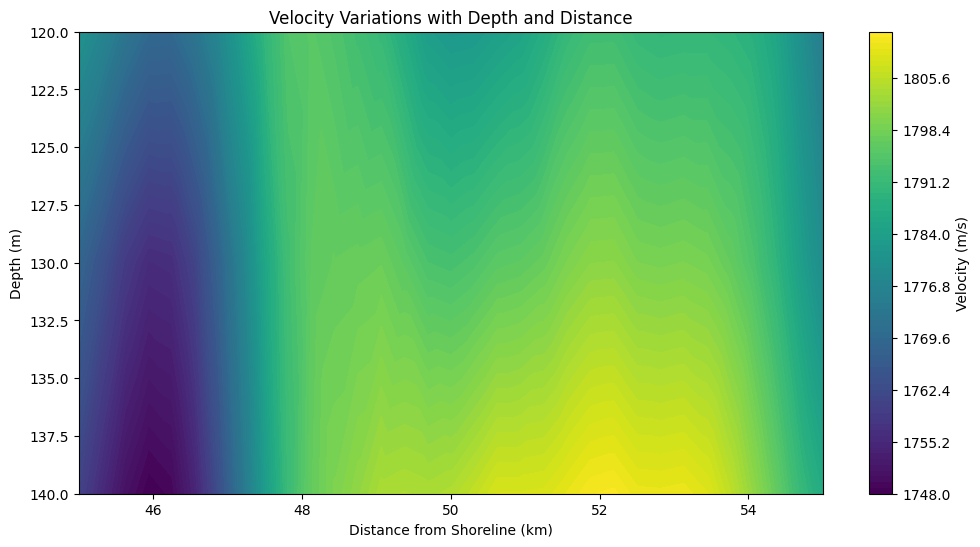

In [ ]:
# Extract the filtered data columns
distances = velocity_data_filtered['DISTANCE'].values
depths = velocity_data_filtered['DEPTH'].values
velocities = velocity_data_filtered['VELOCITY'].values

# Define grid for interpolation
distance_grid = np.linspace(45, 55, 700)  # Increase number of points for smoother contours
depth_grid = np.linspace(120, 140, 700)

# Interpolate the data onto a regular grid for contour plotting
velocity_grid = griddata(
    (distances, depths),
    velocities,
    (distance_grid[None, :], depth_grid[:, None]),
    method='linear'
)

# Create contour plot
plt.figure(figsize=(12, 6))
contour = plt.contourf(distance_grid, depth_grid, velocity_grid, cmap="viridis", levels=100)
plt.colorbar(contour, label="Velocity (m/s)")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()  # Depth should increase downwards
plt.title("Velocity Variations with Depth and Distance")
plt.show()


## Mean value of known freshwater section used in calculations (same completed for saltwater section)

In [ ]:
print(np.mean(velocity_grid))

1788.2018411162485


## Interactive Plot to investigate velocity changes

In [ ]:
# Extract the filtered data columns
distances = velocity_data_filtered['DISTANCE'].values
depths = velocity_data_filtered['DEPTH'].values
velocities = velocity_data_filtered['VELOCITY'].values

# Define grid for interpolation
distance_grid = np.linspace(0, 100, 300)
depth_grid = np.linspace(0, 800, 300)

# Interpolate the data onto a regular grid
velocity_grid = griddata(
    (distances, depths),
    velocities,
    (distance_grid[None, :], depth_grid[:, None]),
    method='linear'
)

# Create interactive contour plot
fig = go.Figure(
    data=go.Contour(
        z=velocity_grid,
        x=distance_grid,  # X-axis: Distance from shoreline
        y=depth_grid,     # Y-axis: Depth
        colorscale="Viridis",
        contours=dict(showlabels=True),  # Show labels on contours
        colorbar=dict(title="Velocity (m/s)")
    )
)

# Customize layout
fig.update_layout(
    title="Interactive Velocity Variations with Depth and Distance",
    xaxis_title="Distance from Shoreline (km)",
    yaxis_title="Depth (m)",
    yaxis=dict(autorange="reversed")  # Invert y-axis to show depth increasing downward
)

fig.show()


### Values for entire section

In [ ]:
mean_velocity = np.mean(velocities)
std_velocity = np.std(velocities)
min_velocity = np.min(velocities)
max_velocity = np.max(velocities)

print(f"Mean Velocity: {mean_velocity:.2f} m/s")
print(f"Standard Deviation of Velocity: {std_velocity:.2f} m/s")
print(f"Min Velocity: {min_velocity:.2f} m/s")
print(f"Max Velocity: {max_velocity:.2f} m/s")

Mean Velocity: 1956.11 m/s
Standard Deviation of Velocity: 232.12 m/s
Min Velocity: 1480.56 m/s
Max Velocity: 2688.75 m/s


## Defining functions to calculate acoustic impedance and correlation coefficents

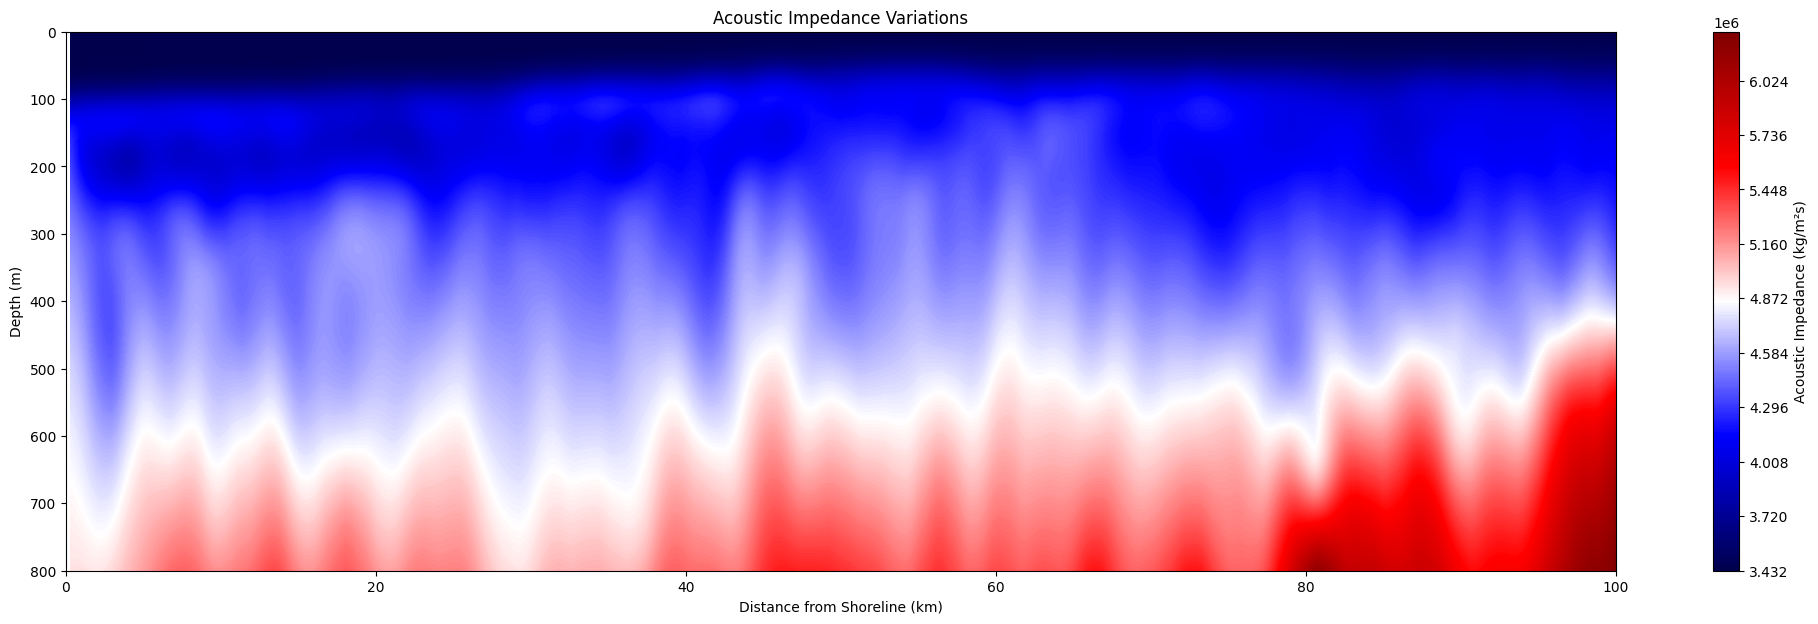

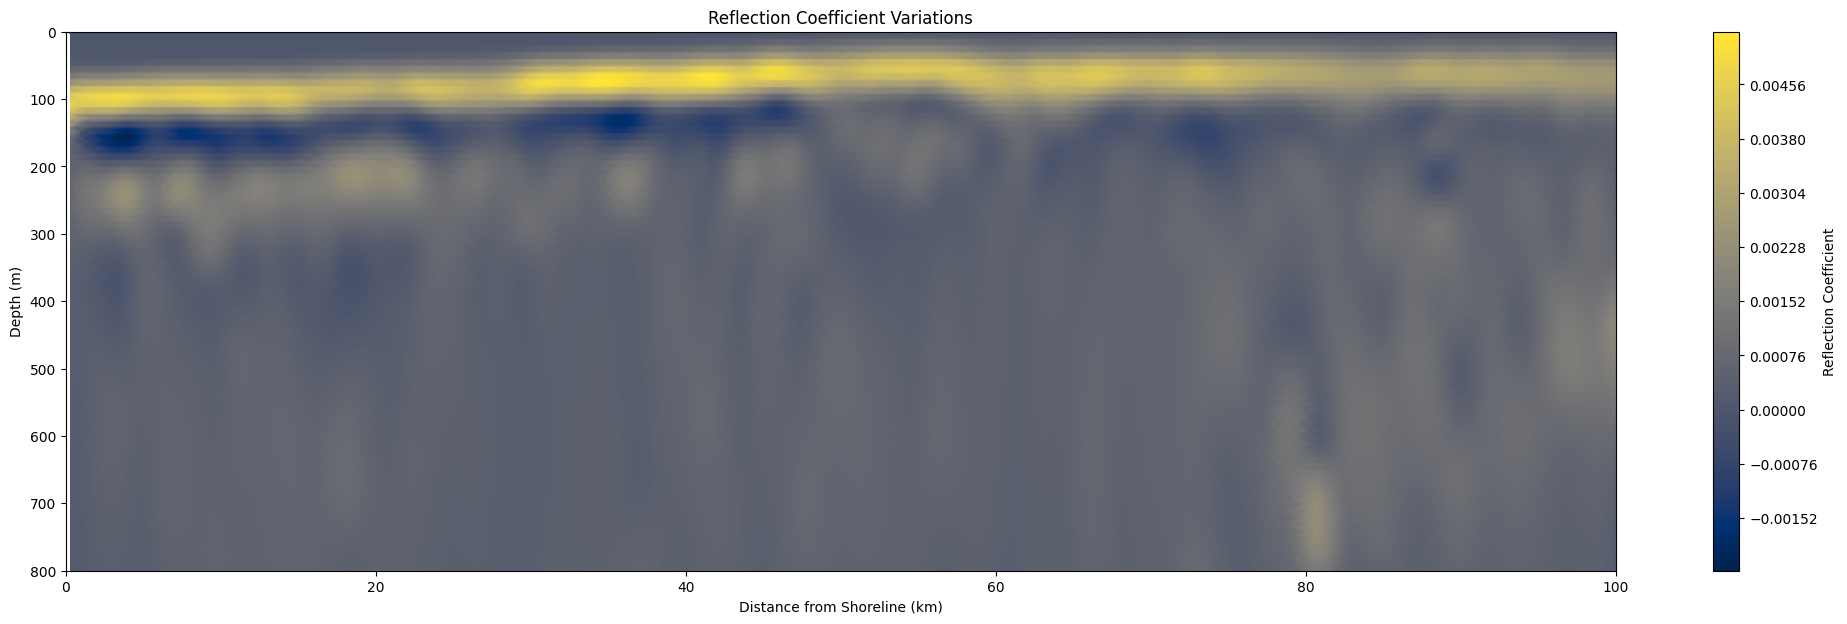

In [ ]:
# Constants for known densities
density_freshwater = 1000  # kg/m³
density_saltwater = 1024  # kg/m³

# Calculate bulk density using your formula
def calculate_bulk_density(porosity, density_water, density_grain=2650):
    """
    Calculate bulk density using:
    density_b = porosity * density_water + (1 - porosity) * density_grain
    """
    return porosity * density_water + (1 - porosity) * density_grain

# Calculate acoustic impedance
def calculate_acoustic_impedance(velocity_data, density_model):
    """
    Calculate acoustic impedance (Z = rho * V) for velocity and density.
    """
    return velocity_data['VELOCITY'] * density_model

# Generate grid for visualization
def create_acoustic_impedance_grid(velocity_data, density_model, depth_min, depth_max):
    """
    Generate a grid of acoustic impedance values for contour plotting.
    """
    acoustic_impedance = calculate_acoustic_impedance(velocity_data, density_model)

    # Interpolate onto a grid
    grid_x, grid_y = np.linspace(0, 100, 300), np.linspace(depth_min, depth_max, 300)
    grid_z = griddata(
        (velocity_data['DISTANCE'], velocity_data['DEPTH']),
        acoustic_impedance,
        (grid_x[None, :], grid_y[:, None]),
        method='linear',
    )
    return grid_x, grid_y, grid_z

# Example porosity model (adjust as needed for your media)
porosity = 0.2  # based on your data/model
bulk_density = calculate_bulk_density(porosity, density_freshwater)

# Create a grid of acoustic impedance values
grid_x, grid_y, grid_z = create_acoustic_impedance_grid(velocity_data, bulk_density, 0, 800)

# Plot the acoustic impedance as a contour
plt.figure(figsize=(25, 7))
contour = plt.contourf(grid_x, grid_y, grid_z, cmap="seismic", levels=500)
plt.colorbar(contour, label="Acoustic Impedance (kg/m²s)")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Acoustic Impedance Variations")
plt.show()

# Calculate reflection coefficients
def calculate_reflection_coefficients(grid_z):
    """
    Calculate reflection coefficients between adjacent layers.
    """
    reflection_coefficients = np.zeros_like(grid_z)
    for i in range(1, grid_z.shape[0]):
        reflection_coefficients[i, :] = (grid_z[i, :] - grid_z[i-1, :]) / (grid_z[i, :] + grid_z[i-1, :] + 1e-10)
    return reflection_coefficients

reflection_grid = calculate_reflection_coefficients(grid_z)

# Plot reflection coefficients
plt.figure(figsize=(25, 7))
reflection_contour = plt.contourf(grid_x, grid_y, reflection_grid, cmap="cividis", levels=500)
plt.colorbar(reflection_contour, label="Reflection Coefficient")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Reflection Coefficient Variations")
plt.show()


## The code below was used to view different known transition sections determined from overlaying our above plots atop the processed EM data. The currently ran plot depicts the acoustic impedance of the assumed saltwater-saltier water boundary.

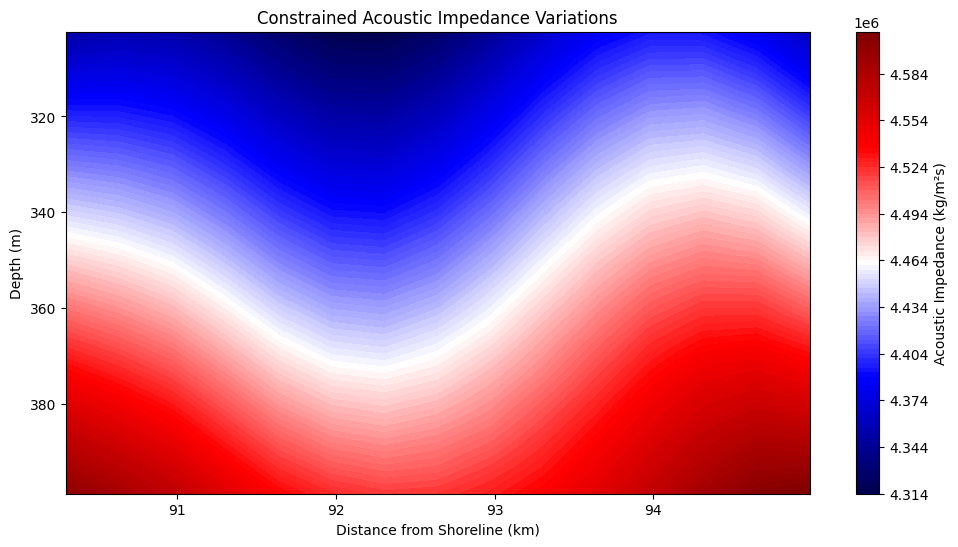

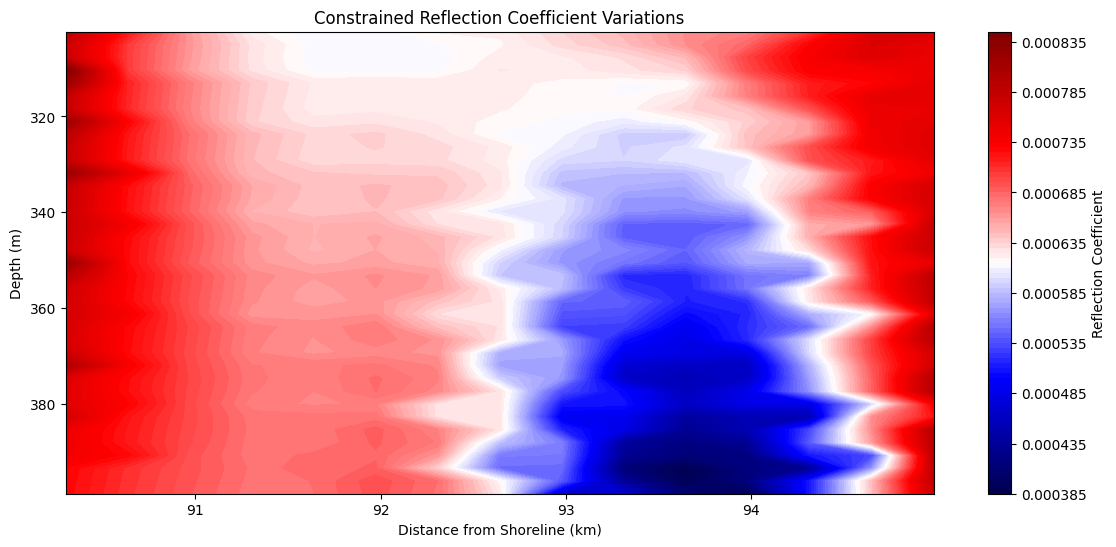

In [ ]:
# Generate acoustic impedance grid
grid_x, grid_y, acoustic_impedance_grid = create_acoustic_impedance_grid(velocity_data, bulk_density, 0, 800)

# Calculate reflection coefficients
reflection_coefficient_grid = calculate_reflection_coefficients(acoustic_impedance_grid)

# Define constrained ranges
depth_min, depth_max = 300, 400  # Depth range in meters
distance_min, distance_max = 90, 95  # Distance range in kilometers

# Create masks for the constrained ranges
depth_mask = (grid_y >= depth_min) & (grid_y <= depth_max)
distance_mask = (grid_x >= distance_min) & (grid_x <= distance_max)

# Apply masks to the grids
constrained_grid_y = grid_y[depth_mask]
constrained_grid_x = grid_x[distance_mask]
constrained_acoustic_impedance_grid = acoustic_impedance_grid[np.ix_(depth_mask, distance_mask)]
constrained_reflection_coefficient_grid = reflection_coefficient_grid[np.ix_(depth_mask, distance_mask)]

# Plot constrained Acoustic Impedance Variations
plt.figure(figsize=(12, 6))
plt.contourf(
    constrained_grid_x,
    constrained_grid_y,
    constrained_acoustic_impedance_grid,
    cmap="seismic",
    levels=100
)
plt.colorbar(label="Acoustic Impedance (kg/m²s)")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.title("Constrained Acoustic Impedance Variations")
plt.gca().invert_yaxis()
plt.show()

# Plot constrained Reflection Coefficient Variations
plt.figure(figsize=(14, 6))
plt.contourf(
    constrained_grid_x,
    constrained_grid_y,
    constrained_reflection_coefficient_grid,
    cmap="seismic",
    levels=100
)
plt.colorbar(label="Reflection Coefficient")
plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.title("Constrained Reflection Coefficient Variations")
plt.gca().invert_yaxis()
plt.show()

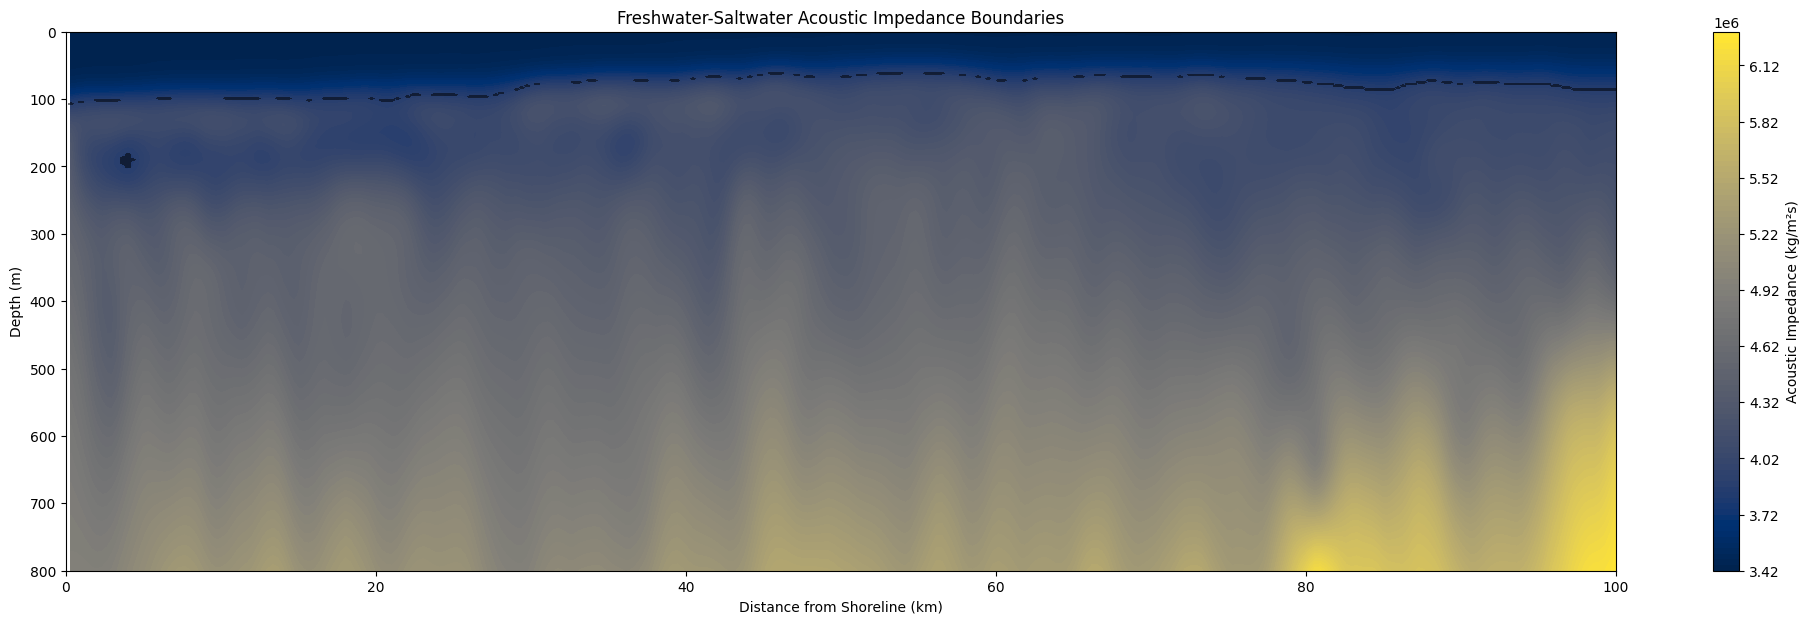

In [ ]:
# Define the range of acoustic impedance for highlighting
acoustic_impedance_min = 3.844e6  # Convert to consistent units (kg/m²s)
acoustic_impedance_max = 3.86e6  # Convert to consistent units (kg/m²s)

# Create a mask for the specified range
highlight_mask = (acoustic_impedance_grid >= acoustic_impedance_min) & (acoustic_impedance_grid <= acoustic_impedance_max)

# Create the full acoustic impedance plot
plt.figure(figsize=(25, 7))
contour = plt.contourf(
    grid_x,
    grid_y,
    acoustic_impedance_grid,
    cmap="cividis",
    levels=100
)
plt.colorbar(contour, label="Acoustic Impedance (kg/m²s)")

# Overlay filled regions for the highlighted mask
plt.contourf(
    grid_x,
    grid_y,
    highlight_mask,
    levels=[0.5, 1],  # Only fill the True regions of the mask
    colors="black",
    alpha=0.5  # Adjust transparency for visibility
)

plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.title("Freshwater-Saltwater Acoustic Impedance Boundaries")
plt.gca().invert_yaxis()
plt.show()


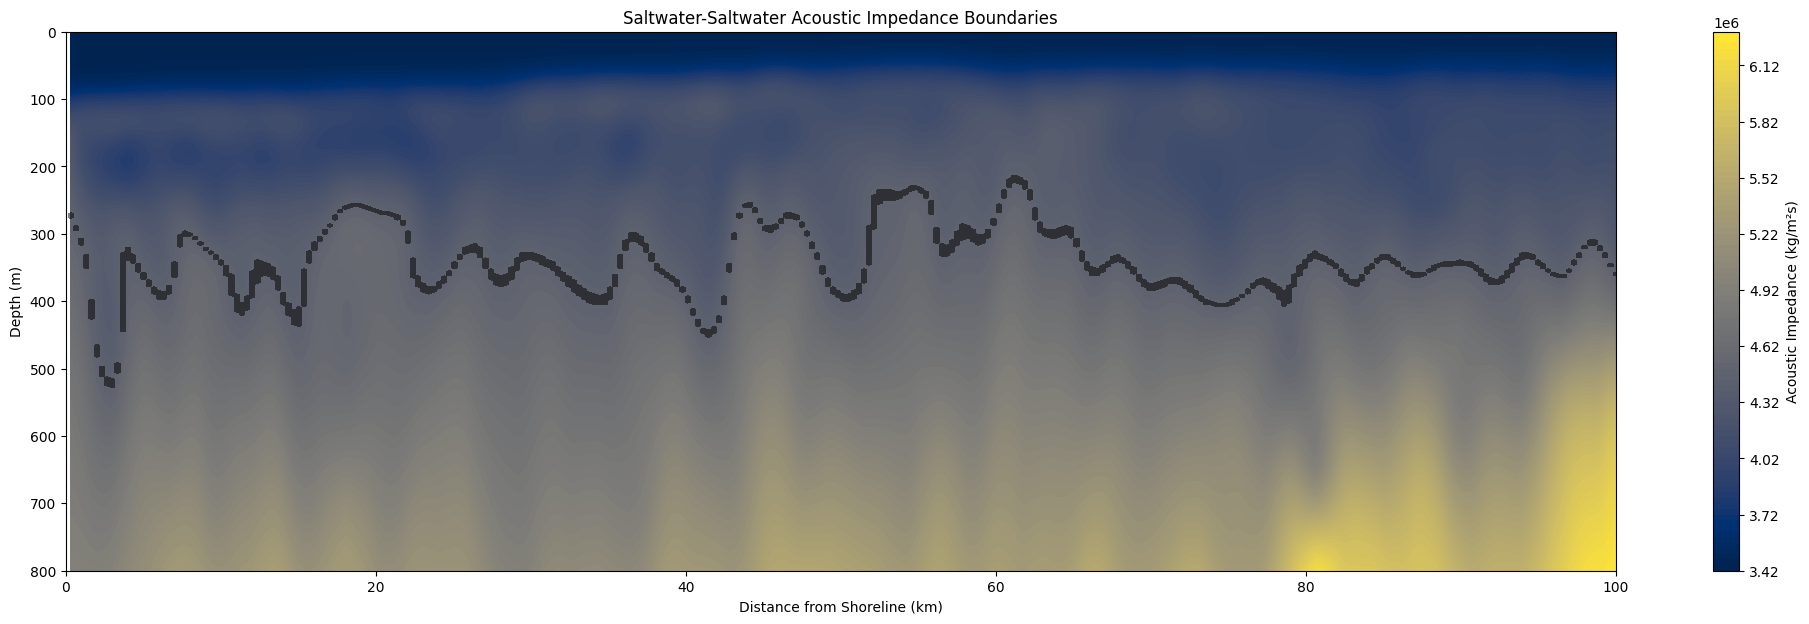

In [ ]:
# Define the range of acoustic impedance for highlighting
acoustic_impedance_min = 4.45e6  # Convert to consistent units (kg/m²s)
acoustic_impedance_max = 4.47e6  # Convert to consistent units (kg/m²s)

# Create a mask for the specified range
highlight_mask = (acoustic_impedance_grid >= acoustic_impedance_min) & (acoustic_impedance_grid <= acoustic_impedance_max)

# Create the full acoustic impedance plot
plt.figure(figsize=(25, 7))
contour = plt.contourf(
    grid_x,
    grid_y,
    acoustic_impedance_grid,
    cmap="cividis",
    levels=100
)
plt.colorbar(contour, label="Acoustic Impedance (kg/m²s)")

# Overlay filled regions for the highlighted mask
plt.contourf(
    grid_x,
    grid_y,
    highlight_mask,
    levels=[0.5, 1],  # Only fill the True regions of the mask
    colors="black",
    alpha=0.5  # Adjust transparency for visibility
)

plt.xlabel("Distance from Shoreline (km)")
plt.ylabel("Depth (m)")
plt.title("Saltwater-Saltwater Acoustic Impedance Boundaries")
plt.gca().invert_yaxis()
plt.show()